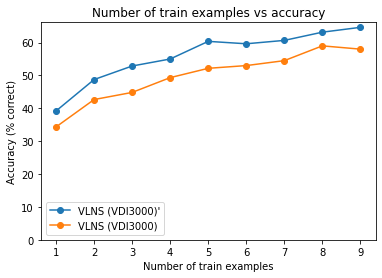

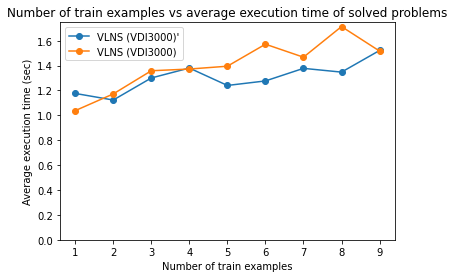

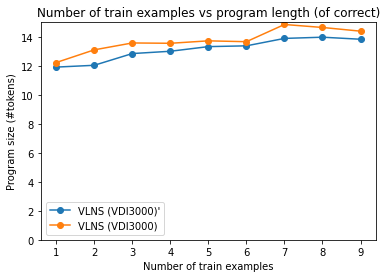

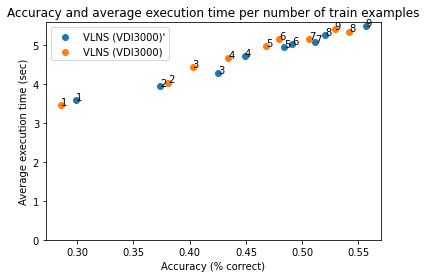

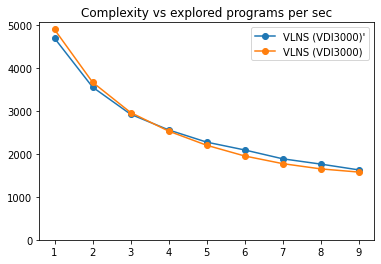

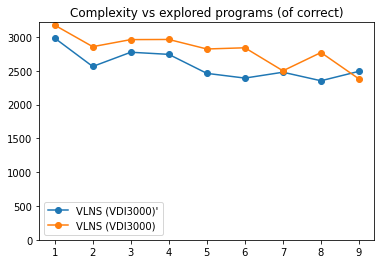

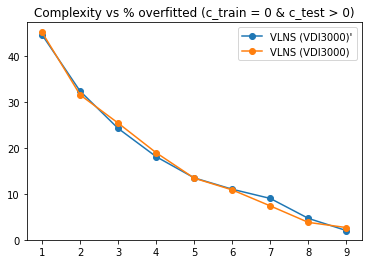

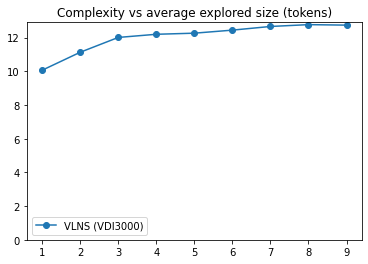

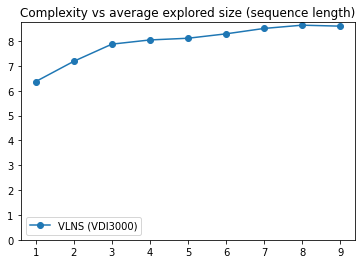

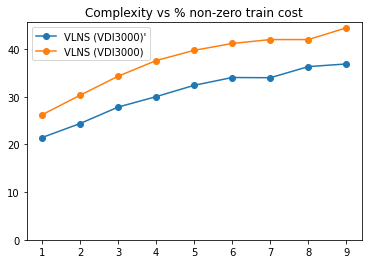

In [6]:
import json
import os
from collections import Callable
import matplotlib.pyplot as plt

class Results:
    def __init__(self, data):
        self.results = [Result(d["file"], d["name"]) for d in data]

    def filter_fields(self, fields: list[str]):
        for r in self.results:
            r.filter_fields(fields)

    def aggregate(self, over: str):
        for r in self.results:
            r.aggregate(over)

    def filter(self, field: str, cond: Callable[[object], bool]):
        for r in self.results:
            r.filter(field, cond)

    def filter_all(self, id_field: str, field: str, cond: Callable[[object], bool]):

        d = {}
        for r in self.results:
            for e in r.results:
                if e[id_field] not in d:
                    d[e[id_field]] = []

                if cond(Result._field_parser(e, field)):
                    d[e[id_field]].append(e)

        l = len(self.results)
        for i in range(0, l):
            self.results[i].results = [v[i] for k, v in d.items() if len(v) == l]

    def plot(self, x: Callable, y: Callable, title: str = "", x_axis: str = "", y_axis: str = ""):
        fig, ax = plt.subplots()

        for r in self.results:
            r.plot(x, y, ax)

        ax.set_ylim(bottom=0)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.legend()
        plt.title(title)

    def scatter_plot(self, x: Callable, y: Callable, label: Callable, title: str = "", x_axis: str = "", y_axis: str = ""):
        fig, ax = plt.subplots()

        for r in self.results:
            r.scatter_plot(x, y, label, ax)

        ax.set_ylim(bottom=0)
        plt.xlabel(x_axis)
        plt.ylabel(y_axis)
        plt.legend()
        plt.title(title)

    def save(self, domain: str, name: str):
        folder = "{}/graphs/{}".format(os.getcwd(), domain)

        if not os.path.exists(folder):
            os.makedirs(folder)

        plt.savefig("{}/{}.pdf".format(folder, name))

class Result:
    def __init__(self, file_name, name):
        self.name = name

        self.results = []

        with open(file_name, "r") as file:
            for line in file:
                stripped_line = line.strip()
                obj = json.JSONDecoder().decode(stripped_line)
                self.results.append(obj)

    def filter_fields(self, fields: list[str]):
        for i, res in enumerate(self.results):
            self.results[i] = {f: self._field_parser(res, f) for f in fields}

    @staticmethod
    def _field_parser(obj, field):
        if field == "complexity":
            return int(obj["file"].split("/")[1].split("-")[0])

        if field == "file_tuple":
            a = obj["file"].split("/")[1][:-3].split("-")
            return int(a[0]), int(a[1]), int(a[2])

        if field == "correct":
            return 1 if obj["test_cost"] == obj["train_cost"] == 0 else 0

        if field == "zero_train_cost":
            return 1 if obj["train_cost"] == 0 else 0

        if field == "overfitted":
            return 1 if obj["test_cost"] > 0 and obj["train_cost"] == 0 else 0

        if field == "explored_per_sec":
            return obj["number_of_explored_programs"] / obj["execution_time"]

        if field == "average_explored_size_tokens":
            a = obj["explored_per_size_tokens"]
            return sum([a*b for a,b in enumerate(a)]) / sum(a)

        if field == "average_explored_size_sequence":
            a = obj["explored_per_size_sequence"]
            return sum([a*b for a,b in enumerate(a)]) / sum(a)

        if field in obj:
            return obj[field]

        raise Exception()

    def aggregate(self, over: str):
        final = {}

        for res in self.results:
            key = res[over]

            if key not in final:
                final[key] = {"dict": res, "count": 1}
            else:
                final[key]["count"] += 1
                for f in res:
                    final[key]["dict"][f] += res[f]

        for key, value in final.items():
            final[key] = {k: value["dict"][k] / value["count"] for k, v in value["dict"].items()}

        self.results = final

    def filter(self, field: str, cond: Callable[[object], bool]):
        result = []

        for res in self.results:
            if cond(self._field_parser(res, field)):
                result.append(res)

        self.results = result

    def plot(self, x: Callable, y: Callable, ax):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]

        ax.plot(
            xs, ys,
            label=self.name,
            marker='o'
        )

    def scatter_plot(self, x: Callable, y: Callable, label: Callable, ax):
        xs = [x(r) for r in self.results.items()]
        ys = [y(r) for r in self.results.items()]

        ax.scatter(
                xs, ys,
                label=self.name,
                marker='o'
        )

        labels = [label(r) for r in self.results.items()]

        for x, y, l in zip(xs, ys, labels):
            ax.annotate(l, (x, y))

    def __str__(self):
        return self.results.__str__()

domain = "string"
datas = {
    "robot": [
        {"name": "Brute", "file": "results/robot/brute-20211221-145101.txt"},
        {"name": "VLNS", "file": "results/robot/VLNS-20211221-145121.txt"},
        {"name": "VLNS (VDI3000)", "file": "results/robot/VLNS_vdi-20211221-145147.txt"}],
    "string": [
        #{"name": "Brute", "file": "results/hpc/string/brute-20211222-204643.txt"},
        #{"name": "VLNS", "file": "results/hpc/string/VLNS-20211222-205850.txt"},
        {"name": "VLNS (VDI3000)'", "file": "results/hpc/string/VLNS_vdi-20211223-111324.txt"},
        #{"name": "VLNS (VDI1000)", "file": "results/hpc/string/VLNS_vdi1000-20211223-163100.txt"},
        #{"name": "VLNS (VDI2000)", "file": "results/hpc/string/VLNS_vdi2000-20211223-164230.txt"},
        {"name": "VLNS (VDI3000)", "file": "results/hpc/string/VLNS_vdi3000-20211223-165348.txt"}],


}
complexity = {
    "robot": "Grid size",
    "string": "Number of train examples",
    "pixels": "idk",
}[domain]

data = datas[domain]

#"""     Complexity vs accuracy

results = Results(data)
results.filter("file_tuple", lambda v: v[1] <= 200)
results.filter_fields(["complexity", "correct"])
results.aggregate("complexity")
results.plot(
    x=lambda t: t[0],
    y=lambda t: t[1]["correct"]*100,
    title="{} vs accuracy".format(complexity),
    x_axis=complexity,
    y_axis="Accuracy (% correct)"
)
results.save(domain, "complexity_vs_accuracy")
#"""

#"""     Complexity vs execution time of correct

results = Results(data)
results.filter("correct", lambda v: v == 1)
#results.filter_all("file", "correct", lambda v: v == 1)
results.filter_fields(["complexity", "execution_time"])
results.aggregate("complexity")
results.plot(
    x=lambda t: t[0],
    y=lambda t: t[1]["execution_time"],
    title="{} vs average execution time of solved problems".format(complexity),
    x_axis=complexity,
    y_axis="Average execution time (sec)",
)
results.save(domain, "complexity_vs_execution_time")
#"""

#"""     Complexity vs program length of correct

results = Results(data)
results.filter("correct", lambda v: v == 1)
#results.filter_all("file", "correct", lambda v: v == 1)
results.filter_fields(["complexity", "program_length"])
results.aggregate("complexity")
results.plot(
    x=lambda t: t[0],
    y=lambda t: t[1]["program_length"],
    title="{} vs program length (of correct)".format(complexity),
    x_axis=complexity,
    y_axis="Program size (#tokens)",
)
#"""

# Per complexity (execution time, accuracy)
results = Results(data)
results.filter("file_tuple", lambda v: v[2] in [1,2,3])
results.filter_fields(["complexity", "execution_time", "correct"])
results.aggregate("complexity")
results.scatter_plot(
    x=lambda t: t[1]["correct"],
    y=lambda t: t[1]["execution_time"],
    label=lambda t: int(t[1]["complexity"]),
    title="Accuracy and average execution time per {}".format(complexity.lower()),
    x_axis="Accuracy (% correct)",
    y_axis="Average execution time (sec)",
)
results.save(domain, "exe_time_and_accuracy_per_complexity")

# Complexity vs explored programs per second
results = Results(data)
results.filter_fields(["complexity", "explored_per_sec"])
results.aggregate("complexity")
results.plot(lambda t: t[0], lambda t: t[1]["explored_per_sec"], title="Complexity vs explored programs per sec")

# Complexity vs explored programs (of correct)
results = Results(data)
results.filter("correct", lambda v: v == 1)
results.filter_fields(["complexity", "number_of_explored_programs"])
results.aggregate("complexity")
results.plot(lambda t: t[0], lambda t: t[1]["number_of_explored_programs"], title="Complexity vs explored programs (of correct)")

# Complexity vs % overfitted (c_train = 0 and c_test > 0)
results = Results(data)
results.filter_fields(["complexity", "overfitted"])
results.aggregate("complexity")
results.plot(lambda t: t[0], lambda t: t[1]["overfitted"]*100, title="Complexity vs % overfitted (c_train = 0 & c_test > 0)")

# Complexity vs average explored size (tokens)
results = Results(data[1:])
results.filter_fields(["complexity", "average_explored_size_tokens"])
results.aggregate("complexity")
results.plot(lambda t: t[0], lambda t: t[1]["average_explored_size_tokens"], title="Complexity vs average explored size (tokens)")

# Complexity vs average explored size (sequence length)
results = Results(data[1:])
results.filter_fields(["complexity", "average_explored_size_sequence"])
results.aggregate("complexity")
results.plot(lambda t: t[0], lambda t: t[1]["average_explored_size_sequence"], title="Complexity vs average explored size (sequence length)")

# Complexity vs % non-zero train cost
results = Results(data)
results.filter_fields(["complexity", "zero_train_cost"])
results.aggregate("complexity")
results.plot(lambda t: t[0], lambda t: (1-t[1]["zero_train_cost"])*100, title="Complexity vs % non-zero train cost")